<h1>Exploratory Data Analysis</h1>

Let's start by a few imports :

In [1]:
from sales_forecast import forecast_model
from numpy import linspace
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We create the model, who imports the data, then sets some graphics parameters :

In [2]:
model = forecast_model()

print(model.stores.head())
print(model.stores.describe())

print(len(model.train_data['ts_id'].unique()))

#TODO add the rest of graphic tuning
sns.set_style("darkgrid")

   ts_id Store                      SKU
0      0  3301     _Baltika №0 Can 0,45
1      1  3301     _Baltika №3 Can 0,45
2      2  3301     _Baltika №7 Can 0,45
3      3  3301  _Baltika №7 Bottle 0,47
4      4  3301     _Baltika №9 Can 0,45
             ts_id
count  1944.000000
mean   1054.082819
std     587.173114
min       0.000000
25%     566.750000
50%    1064.500000
75%    1555.250000
max    2063.000000
1891


Let's begin by have a loook on the sales figure :

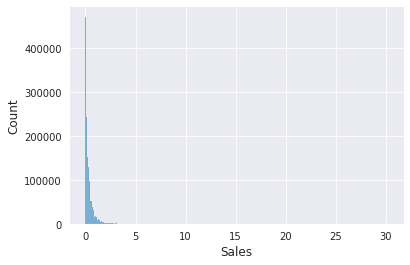

In [3]:
sns.histplot(data=model.train_data, x="Sales", binwidth=0.1)
plt.show()

It seems that there is some outliers : lets's remove the data over 3 to have a better view.

Text(0.5, 1.0, 'Values of sales without outliers')

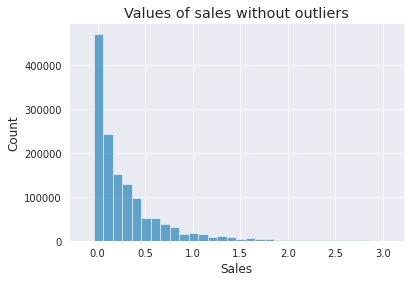

In [4]:
data_clean = model.train_data[model.train_data.Sales < 3]
sns.histplot(data=data_clean, x="Sales", binwidth=0.1)
plt.title("Values of sales without outliers")



<h2>Analysis of the outliers</h2>

Let's have a look at these outliers :

In [5]:
outliers = model.train_data[model.train_data.Sales > 3]
print(outliers.sort_values('Sales', ascending=False))

               Date  ts_id  isPromo   Sales
95757    2015-08-04   1333      1.0  30.200
1303372  2017-05-04    571      1.0  22.410
1302201  2017-05-03   1319      1.0  18.900
1303449  2017-05-04    648      1.0  18.540
98022    2015-08-05   1707      1.0  18.100
...             ...    ...      ...     ...
949743   2016-10-29    559      2.0   3.010
1160895  2017-02-17   1866      1.0   3.008
1155291  2017-02-14   1954      1.0   3.008
1159684  2017-02-17    599      1.0   3.008
1165496  2017-02-20    743      1.0   3.008

[6213 rows x 4 columns]


So we have 6213 outliers out of 1.3 million. Let's dive in the data to understand them better. Let's beign by plot their dates to see if there is a correlation :

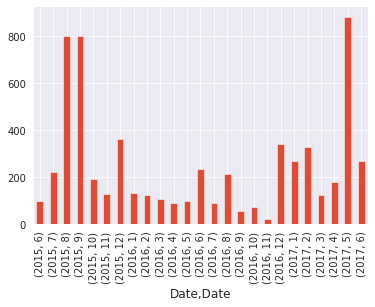

In [6]:
outliers["Date"] = outliers["Date"].astype("datetime64")
outliers["Sales"].groupby([outliers["Date"].dt.year, outliers["Date"].dt.month]).count().plot(kind="bar")
plt.show()

We can see that the distribution of outliers is kind of homogenous, except for August-September 2015 and for May 2017. Now let's have a look in which stores they occurs.

In [7]:
stores_with_outliers = []
for ts_id in outliers["ts_id"].unique():
        stores_with_outliers.append(model.stores["Store"][model.stores['ts_id'] == ts_id])

unique, counts = numpy.unique(stores_with_outliers, return_counts=True)
d = dict(zip(unique, counts))
print(f"""Number of shops with outliers : {len(unique)} out of {len(model.stores["Store"].unique())}.""")


# see for each store, the proportion of outliers

Number of shops with outliers : 241 out of 267.


<h2>Analysis of the stores</h2>

We can plot all the time-series of one particular store, to see if they all follow the same pattern (TODO):

In [8]:
def plot_time_serie(model, index):
    data = model.train_data[model.train_data.ts_id == index]
    #We retrieve the infos about this time-serie
    sku = model.stores['SKU'][index]
    store = model.stores['Store'][index]
    sns.lineplot(x="Date", y="Sales", data=data)
    plt.xticks(ticks=linspace(0, len(data.Date), 10), rotation=15)
    plt.title("Time-Serie of {} in the store {}".format(sku, store))
    plt.show()
    
    
def plot_full_store_time_series(model, store):
    stores_data = model.stores.loc[model.stores['Store'] == store]
    time_series = stores_data['ts_id']
    for i, t_s in enumerate(time_series):
        plot_time_serie(model, t_s)
    #plt.show()

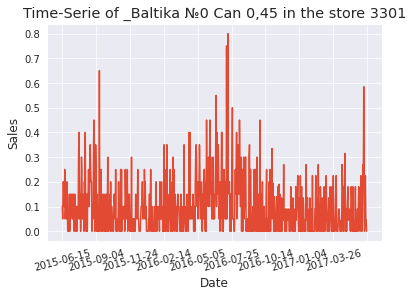

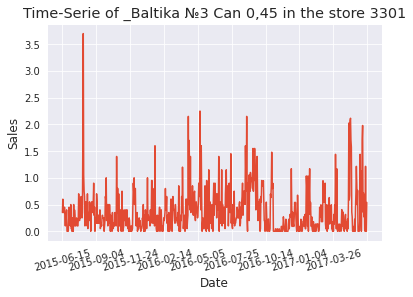

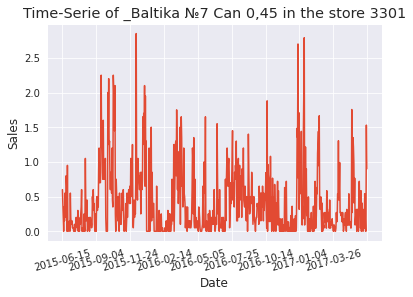

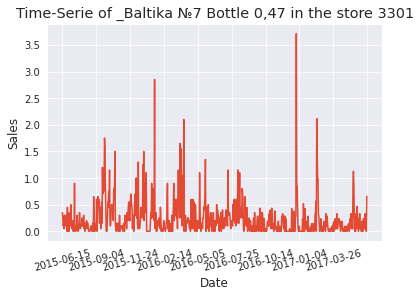

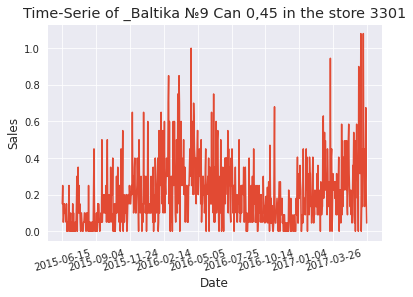

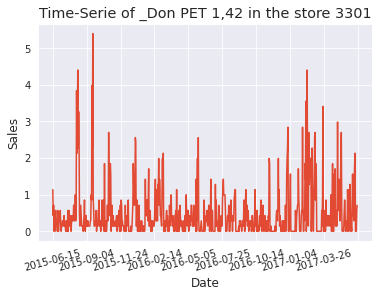

In [9]:
plot_full_store_time_series(model, '3301')

In [10]:
def plot_hist_sku(model, feature, hue=None):
    """Plot the histogram representing the distribution of sku across the features [Segment, Pack, Product], and cross it with another feature as color"""
    if feature not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect feature name. Should be one of these : "Segment", "Pack", "Product".""")
    if hue not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect hue name. Should be one of these : "Segment", "Pack", "Product".""")
    sns.histplot(data=model.features, y=feature, hue=hue)
    plt.title("Types of " + feature)
    plt.show()

Let's plot the repartition of the different types of products, and cross it with another features to see if there's something interesting :

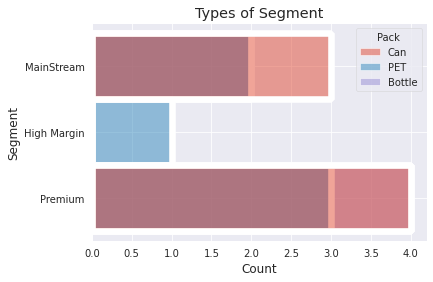

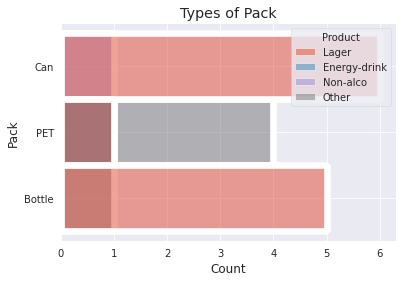

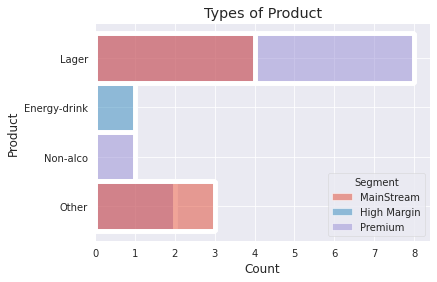

In [11]:
plot_hist_sku(model, "Segment", hue="Pack")
plot_hist_sku(model, "Pack", hue="Product")
plot_hist_sku(model, "Product", hue="Segment")
plt.show()

We can see that only the PET packages are High-margin, and that the high-margin are actually just the energy drinks. We can as a consequence treat these separately from the beers.

Now, let's plot the actual volume of sales by pondering the figures with the actual sales numbers :